In [2]:
import pandas as pd
import numpy as np
import os

In [90]:
df_residencias = pd.read_csv('../planilhas/residencias.csv')
df_residencias['Longitude'] = df_residencias['Longitude'] / 1e1
df_residencias['Latitude'] = df_residencias['Latitude'] / 1e1

In [91]:
df_residencias.head()

,ID,Longitude,Latitude,Z,Measure,OID_,ORIG_FID,x,y,REGIAO,LINK_ID,NODE_ID,HAB/EDIF 2022,DEMANDA_RECICLAGEM,Container 10
0,1,-4380886.8,-1670242.3,NaN,NaN,0.0,0,-4876780.91,-1873939.00,5,5698,4366,1.028188,0.195356,4518
1,2,-4380885.9,-1670236.6,NaN,NaN,0.0,1,-4876779.90,-1873932.49,5,5698,4366,1.028188,0.195356,4518
2,3,-4380884.2,-1670232.6,NaN,NaN,0.0,2,-4876777.97,-1873927.80,5,5696,4366,1.028188,0.195356,4518
3,4,-4380881.8,-1670228.8,NaN,NaN,0.0,3,-4876775.26,-1873923.43,5,5696,4366,1.028188,0.195356,4518
4,5,-4380879.0,-1670224.8,NaN,NaN,0.0,4,-4876772.21,-1873918.81,5,5696,4366,1.028188,0.195356,4518


In [94]:
coordinates_array_residencias = np.array(df_residencias[['Longitude', 'Latitude']]) 

In [ ]:
df_pontos_onibus = pd.read_csv('../planilhas/pontos_tratados.csv')
df_pontos_onibus['Longitude'] = df_pontos_onibus['Longitude'] * 1e5
df_pontos_onibus['Latitude'] = df_pontos_onibus['Latitude'] * 1e5
df_pontos_onibus.head()

,id,Longitude,Latitude
0,0,-4.386667e+06,-1.676006e+06
1,1,-4.387539e+06,-1.674931e+06
2,2,-4.387512e+06,-1.674841e+06
3,3,-4.387194e+06,-1.674988e+06
4,4,-4.387494e+06,-1.675586e+06


In [93]:
coordinates_array_pontos_onibus = np.array(df_pontos_onibus[['Longitude', 'Latitude']]) 

# Associação entre ponto de ônibus e residência

In [27]:
def euclidean_distance(coord):
        return np.sqrt(np.sum(np.square(np.array(coordinates_array_pontos_onibus) - np.array(coord)), axis=1))

In [95]:
distancias_dados = {'pontos': [], 'distancias': []}
for coord in coordinates_array_residencias:
    distancias = euclidean_distance(coord)
    distancias_dados['pontos'].append(np.argmin(distancias))
    distancias_dados['distancias'].append(np.min(distancias))
    # print(ponto_onibus_associado, distancia_associada)

In [96]:
from copy import deepcopy
matriz_coord = deepcopy(coordinates_array_residencias)

for ponto_onibus_associado in coordinates_array_pontos_onibus:
    matriz_coord = np.vstack([matriz_coord, ponto_onibus_associado])


matriz_coord.shape


(133001, 2)

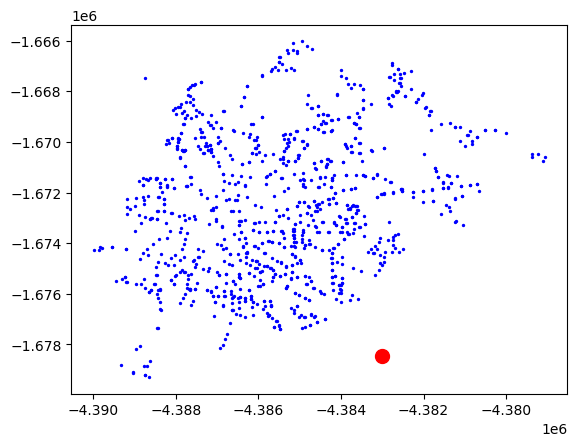

In [97]:
# np.hstack()

import matplotlib.pyplot as plt


plt.scatter(coordinates_array_residencias[82959,0], coordinates_array_residencias[82959, 1], s=100, c = 'red')
# plt.scatter(coordinates_array_residencias[:,0], coordinates_array_residencias[:, 1], s=0.1, c = 'red')
plt.scatter(coordinates_array_pontos_onibus[:,0], coordinates_array_pontos_onibus[:, 1], s=2, c = 'blue')
plt.show()

In [98]:
np.argmax(distancias_dados['distancias'])
np.max(distancias_dados['distancias'])
# distancias_dados['pontos'][82959]

np.float64(2021.981567670753)

,distancias
pontos,
0,66.207471
1,100.800122
2,96.153229
3,130.179730
4,142.666593
...,...
1132,56.691728
1133,69.984483
1134,167.705080


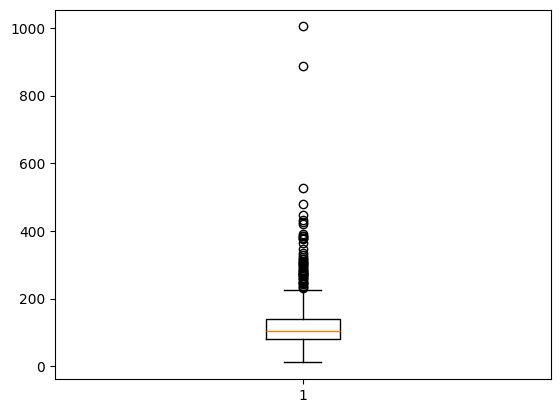

In [99]:
df =pd.DataFrame(distancias_dados)
df = df.groupby(['pontos']).mean()
plt.boxplot(df['distancias'])
df

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, LineString

# Exemplo de dados de pontos de ônibus (substitua pelos seus dados)
dados_pontos = {
    'ponto_id': [1, 2, 3],
    'geometry': [Point([-43.87352, -16.69642]), Point([-43.88644, -16.79298]), Point([-43.87403, -16.6892])], 
    'latitude': [-16.69642, -16.79298, -16.6892],
    'longitude': [-43.87352, -43.88644, -43.87403]
}
df_pontos = pd.DataFrame(dados_pontos)
gdf_pontos = gpd.GeoDataFrame(df_pontos, geometry=gpd.points_from_xy(df_pontos.longitude, df_pontos.latitude))

# Exemplo de dados de linhas de ônibus (substitua pelos seus dados)
dados_linhas = {
    'linha_id': ['7101 - VOLTA', '7103 - IDA', '7103 - VOLTA'],
    'distancia': ['10.2 km', '16.7 km', '18.5 km'],
    'trajeto': [
        LineString([(-43.87352, -16.69642), (-43.87342, -16.69652)]),
        LineString([(-43.88644, -16.79298), (-43.88630, -16.79300)]),
        LineString([(-43.87403, -16.68920), (-43.87448, -16.68910)])
    ]
}
df_linhas = pd.DataFrame(dados_linhas)
gdf_linhas = gpd.GeoDataFrame(df_linhas, geometry='trajeto')

# Definir uma distância de tolerância em metros para associar pontos às linhas
tolerancia = 100  # por exemplo, 100 metros

associacoes = []
for idx_ponto, ponto in gdf_pontos.iterrows():
    for idx_linha, linha in gdf_linhas.iterrows():
        distancia = ponto['geometry'].distance(linha['trajeto'])  # Aqui estamos acessando a geometria diretamente pelo índice da coluna
        if distancia <= tolerancia:
            associacoes.append({'ponto_id': ponto['ponto_id'], 'linha_id': linha['linha_id'], 'distancia': distancia})

# Converter para DataFrame
df_associacoes = pd.DataFrame(associacoes)

# Exibir o DataFrame resultante com as associações
print(df_associacoes)


In [9]:
integracao = pd.read_csv('../planilhas/Matriz_Integracao.csv')
df_int = integracao.groupby(['LINHA ORIGEM', 'SENTIDO ORIGEM']).agg({'LINHA DESTINO': 'count'})
# integracao
df_int

LINHA DESTINO
LINHA ORIGEM SENTIDO ORIGEM               
1501         IDA                        63
             VOLTA                      59
1601         IDA                        55
             VOLTA                      49
1701         IDA                        59
...                                    ...
8201         VOLTA                      50
8401         IDA                        52
             VOLTA                       9
8801         IDA                        67
             VOLTA                       9

[72 rows x 1 columns]

In [14]:
linhas_com_integracao = integracao.drop_duplicates(subset=['LINHA ORIGEM'])
linhas_com_integracao = linhas_com_integracao['LINHA ORIGEM']
linhas_com_integracao

0        1501
122      1601
226      1701
342      1702
471      2201
555      2202
669      2203
756      2601
879      2603
990      2604
1108     3301
1192     3302
1264     3601
1345     4601
1445     4603
1574     4701
1693     5101
1831     5601
1931     5702
2050     5801
2190     5802
2308     5803
2403     5901
2538     5902
2656    6201R
2772     6202
2890     6203
2980     6404
3096    6404A
3200     6604
3262     6901
3342     7101
3468     7103
3601     8201
3702     8401
3763     8801
Name: LINHA ORIGEM, dtype: object